# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:09:04.943258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:09:04.943316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:09:04.944748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-2, who has ID: A22CW0ZHY3NJH8

In [2]:
parameters = {}

user = "users-2"
user_id = "A22CW0ZHY3NJH8"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A2VE83MZF98ITY,B00006H36X,B0015AM9TE,B0015AM9TE
1,AGOPHR5HJ0JIZ,B00006H36X,B00OIOB90E,B00CLA0X40
2,A208ESSSDSLWIN,B00006H36X,B008W8IC4I,B0019IN1F8
3,A1RRBA1S9S10SB,B00006H36X,B00134MXF2,B00134MXF2
4,AYJU1B9E4STIL,B00006H36X,B0018CIPS8,B0009IODSS
...,...,...,...,...
65211,A3861YKXL4ICRL,B01G4VVZKW,B000W5QSYA,B01E7NPFXC
65212,A5F6YDTA9JE52,B01GJJHPLC,B000084F1Z,B007CMHWSC
65213,A2MCPVRDURR7P2,B01GJJHPLC,B00L9KIY3A,B0018KOHFK
65214,A80KFPCXKV4BQ,B01GJJHPLC,B0075RW2KC,B01GY6OIBU


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset or has no category, based on the encoding dictionary, which contains only products which are in meta dataset and have category

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 65216
Number of sequences and targets after removal: 64030


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A22CW0ZHY3NJH8
productID                 B01EETDXZ6
purchased_before_1        B00TI6X144
purchased_before_2        B01EAQE0JQ
Name: 416, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 64029
Number of sequences and targets after dropping duplicates: 54279


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 274
Number of unique product IDs in sequences: 24814


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B0015AM9TE', 'B0015AM9TE'],
        ['B00OIOB90E', 'B00CLA0X40'],
        ['B008W8IC4I', 'B0019IN1F8'],
        ['B00134MXF2', 'B00134MXF2'],
        ['B0018CIPS8', 'B0009IODSS'],
        ['B000UGB9EA', 'B0051GCTAW'],
        ['B000UGB9EA', 'B000A216MY'],
        ['B00006H36X', 'B00ERZ3NSA'],
        ['B00ENL0JJO', 'B0174A5WHY'],
        ['B0025V4QAW', 'B00V36WHEW']], dtype=object),
 array(['B00006H36X', 'B00006H36X', 'B00006H36X', 'B00006H36X',
        'B00006H36X', 'B00006H36X', 'B00006H36X', 'B01C47QGPE',
        'B00006H36X', 'B00006H36X'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[20442, 20442],
        [103908, 73289],
        [60226, 22410],
        [20056, 20056],
        [22001, 9118],
        [17244, 43023],
        [17244, 9704],
        [195, 79409],
        [79120, 128351],
        [28997, 113327]], dtype=object),
 array([195, 195, 195, 195, 195, 195, 195, 135238, 195, 195], dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 43403
Number of validation sequences: 5432
Number of test sequences: 5444

Number of train targets: 43403
Number of validation targets: 5432
Number of test targets: 5444

Number of classes (unique product IDs) in the train targets: 268
Number of classes in the validation targets: 272
Number of classes in the test targets: 274


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([14317, 27427], dtype=object),
 array([3854, 5635], dtype=object),
 array([20565, 20565], dtype=object),
 array([11382, 14834], dtype=object),
 array([4041, 16272], dtype=object),
 array([17244, 43023], dtype=object),
 array([16239, 16249], dtype=object),
 array([22001, 9118], dtype=object),
 array([20704, 20704], dtype=object),
 array([19882, 11750], dtype=object)]

In [19]:
y_train[:10]

[195, 195, 195, 195, 195, 195, 195, 195, 195, 195]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
  27/1357 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0680 - f1_score: 0.0530 - f1_score_at_k: 0.1005 - hit_rate_at_k: 0.2738 - loss: 11.8353 - ndcg_at_k: 0.0567                     

I0000 00:00:1714590560.946978    1616 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.1016 - f1_score: 0.0629 - f1_score_at_k: 0.0859 - hit_rate_at_k: 0.3125 - loss: 7.2009 - ndcg_at_k: 0.0698 - val_accuracy: 0.0994 - val_f1_score: 0.1095 - val_f1_score_at_k: 0.1419 - val_hit_rate_at_k: 0.1412 - val_loss: 4.8748 - val_ndcg_at_k: 0.0405
Epoch 2/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1429 - f1_score: 0.1052 - f1_score_at_k: 0.1334 - hit_rate_at_k: 0.3443 - loss: 3.9335 - ndcg_at_k: 0.0826 - val_accuracy: 0.1057 - val_f1_score: 0.1188 - val_f1_score_at_k: 0.1744 - val_hit_rate_at_k: 0.1570 - val_loss: 4.8281 - val_ndcg_at_k: 0.0444
Epoch 3/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1638 - f1_score: 0.1299 - f1_score_at_k: 0.1607 - hit_rate_at_k: 0.3760 - loss: 3.8192 - ndcg_at_k: 0.0922 - val_accuracy: 0.1156 - val_f1_score: 0.1395 - val_f1_score_at_k: 0.2238 - val_hit_rate_at_k: 0.1925 - val_loss: 4.6650 - val_ndcg_at_k: 0.0523
Epoch 4/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/

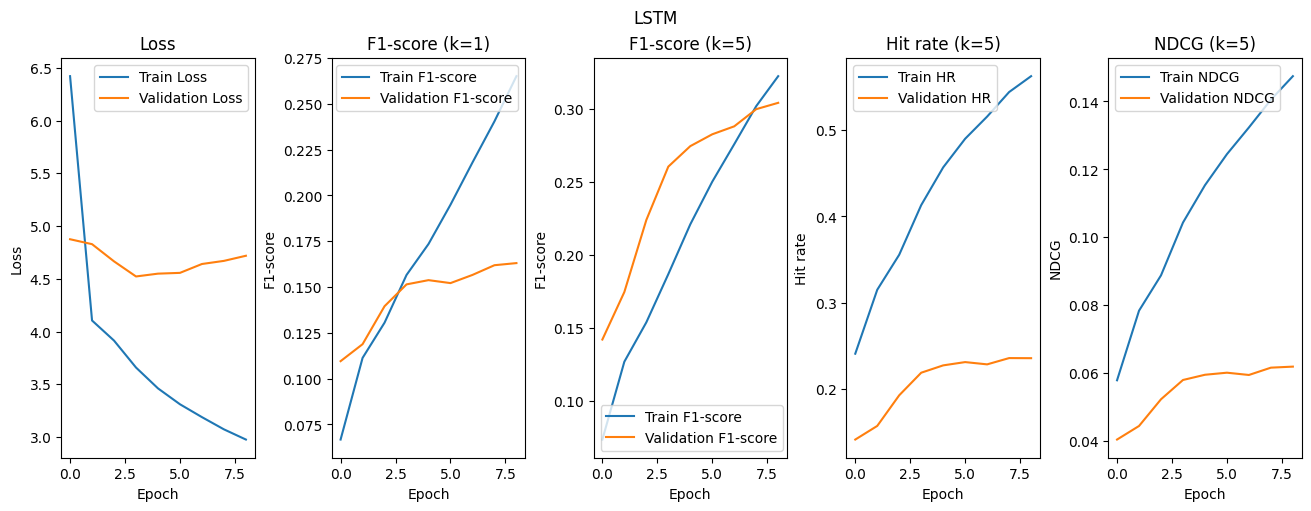

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0820 - f1_score: 0.0991 - f1_score_at_k: 0.1931 - hit_rate_at_k: 0.1457 - loss: 5.1247 - ndcg_at_k: 0.0384        
Test loss: 4.7431
Test accuracy: 0.1286
Test F1@1: 0.1636
Test F1@5: 0.3023
Test HR@5: 0.2341
Test NDCG@5: 0.0617


In [32]:
parameters

{'user': 'users-2',
 'user_id': 'A22CW0ZHY3NJH8',
 'number_of_sequences_and_targets_before_removal': 65216,
 'number_of_sequences_and_targets_after_removal': 64030,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 54279,
 'num_unique_product_ids_in_targets': 274,
 'num_unique_product_ids_in_sequences': 24814,
 'number_of_sequences_and_targets_train': 43403,
 'number_of_sequences_and_targets_validation': 5432,
 'number_of_sequences_and_targets_test': 5444,
 'number_of_unique_products_in_targets_train': 268,
 'number_of_unique_products_in_targets_validation': 272,
 'number_of_unique_products_in_targets_test': 274,
 'model_lstm_test_loss': 4.743081092834473,
 'model_lstm_test_accuracy': 0.1286,
 'model_lstm_test_f1_score_k_1': 0.1636,
 'model_lstm_test_f1_score_k_5': 0.3023,
 'model_lstm_test_hr': 0.2341,
 'model_lstm_test_ndcg': 0.0617}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.1114 - f1_score: 0.0661 - f1_score_at_k: 0.0963 - hit_rate_at_k: 0.3275 - loss: 6.7749 - ndcg_at_k: 0.0740 - val_accuracy: 0.1013 - val_f1_score: 0.1111 - val_f1_score_at_k: 0.1690 - val_hit_rate_at_k: 0.1612 - val_loss: 4.7402 - val_ndcg_at_k: 0.0442
Epoch 2/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.1395 - f1_score: 0.1037 - f1_score_at_k: 0.1300 - hit_rate_at_k: 0.3470 - loss: 3.8861 - ndcg_at_k: 0.0827 - val_accuracy: 0.1064 - val_f1_score: 0.1230 - val_f1_score_at_k: 0.1767 - val_hit_rate_at_k: 0.1602 - val_loss: 4.7563 - val_ndcg_at_k: 0.0455
Epoch 3/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1716 - f1_score: 0.1361 - f1_score_at_k: 0.1626 - hit_rate_at_k: 0.3878 - loss: 3.7134 - ndcg_at_k: 0.0956 - val_accuracy: 0.1198 - val_f1_score: 0.1465 - val_f1_score_at_k: 0.2375 - val_hit_rate_at_k: 0.2047 - val_loss: 4.6012 - val_ndcg_at_k: 0.0553
Epoch 4/50
1357/1357 ━━━━━━━━━━━━━━━

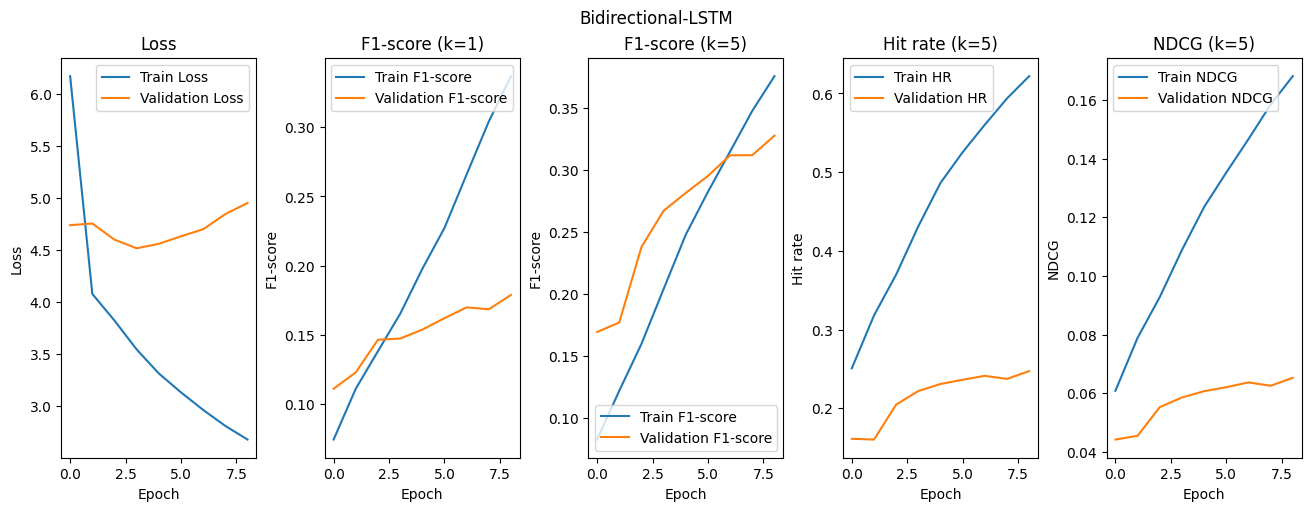

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0880 - f1_score: 0.1108 - f1_score_at_k: 0.2549 - hit_rate_at_k: 0.1838 - loss: 5.2119 - ndcg_at_k: 0.0458
Test loss: 4.9635
Test accuracy: 0.1328
Test F1@1: 0.1756
Test F1@5: 0.3214
Test HR@5: 0.2447
Test NDCG@5: 0.0648


In [37]:
parameters

{'user': 'users-2',
 'user_id': 'A22CW0ZHY3NJH8',
 'number_of_sequences_and_targets_before_removal': 65216,
 'number_of_sequences_and_targets_after_removal': 64030,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 54279,
 'num_unique_product_ids_in_targets': 274,
 'num_unique_product_ids_in_sequences': 24814,
 'number_of_sequences_and_targets_train': 43403,
 'number_of_sequences_and_targets_validation': 5432,
 'number_of_sequences_and_targets_test': 5444,
 'number_of_unique_products_in_targets_train': 268,
 'number_of_unique_products_in_targets_validation': 272,
 'number_of_unique_products_in_targets_test': 274,
 'model_lstm_test_loss': 4.743081092834473,
 'model_lstm_test_accuracy': 0.1286,
 'model_lstm_test_f1_score_k_1': 0.1636,
 'model_lstm_test_f1_score_k_5': 0.3023,
 'model_lstm_test_hr': 0.2341,
 'model_lstm_test_ndcg': 0.0617,
 'model_bi_lstm_test_loss': 4.963522434234619,
 'model_bi_lstm_test_accuracy': 0.1328,
 'model_bi_lstm_test_f1_score_k_1': 0.

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.1121 - f1_score: 0.0679 - f1_score_at_k: 0.0898 - hit_rate_at_k: 0.3207 - loss: 7.1466 - ndcg_at_k: 0.0733 - val_accuracy: 0.0944 - val_f1_score: 0.1076 - val_f1_score_at_k: 0.1574 - val_hit_rate_at_k: 0.1468 - val_loss: 4.9066 - val_ndcg_at_k: 0.0410
Epoch 2/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1437 - f1_score: 0.1071 - f1_score_at_k: 0.1307 - hit_rate_at_k: 0.3518 - loss: 3.9001 - ndcg_at_k: 0.0842 - val_accuracy: 0.1071 - val_f1_score: 0.1257 - val_f1_score_at_k: 0.1985 - val_hit_rate_at_k: 0.1737 - val_loss: 4.7813 - val_ndcg_at_k: 0.0479
Epoch 3/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1746 - f1_score: 0.1341 - f1_score_at_k: 0.1760 - hit_rate_at_k: 0.4108 - loss: 3.7064 - ndcg_at_k: 0.1009 - val_accuracy: 0.1156 - val_f1_score: 0.1377 - val_f1_score_at_k: 0.2476 - val_hit_rate_at_k: 0.2138 - val_loss: 4.5998 - val_ndcg_at_k: 0.0560
Epoch 4/50
1357/1357 ━━━━━━━━━━━━━━━━━

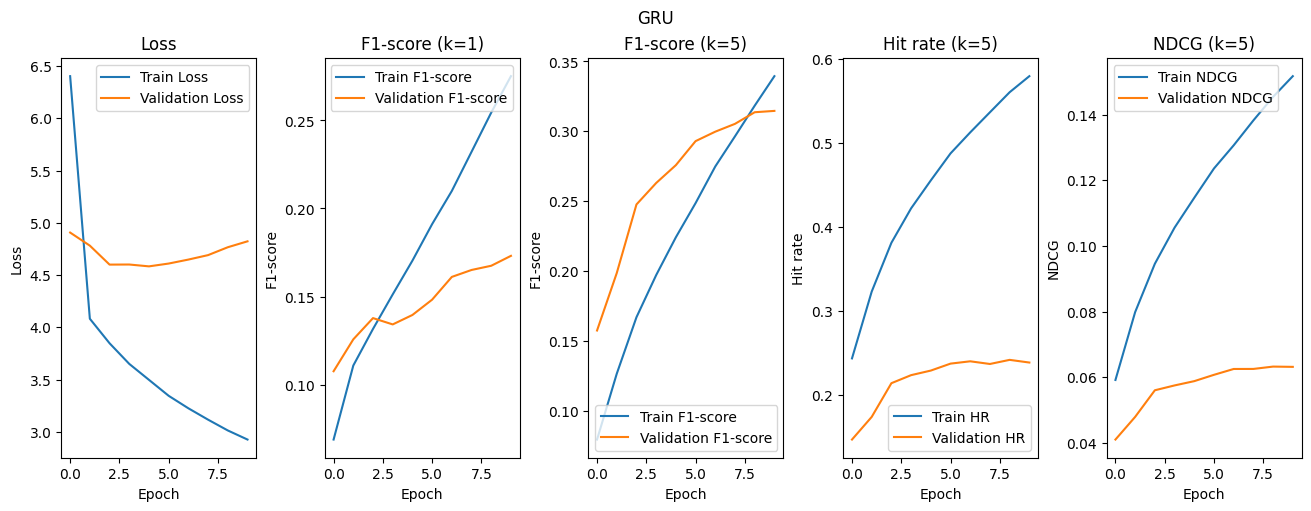

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0856 - f1_score: 0.1077 - f1_score_at_k: 0.2215 - hit_rate_at_k: 0.1620 - loss: 5.1484 - ndcg_at_k: 0.0417        
Test loss: 4.8284
Test accuracy: 0.1332
Test F1@1: 0.1751
Test F1@5: 0.3145
Test HR@5: 0.2398
Test NDCG@5: 0.0639


In [42]:
parameters

{'user': 'users-2',
 'user_id': 'A22CW0ZHY3NJH8',
 'number_of_sequences_and_targets_before_removal': 65216,
 'number_of_sequences_and_targets_after_removal': 64030,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 54279,
 'num_unique_product_ids_in_targets': 274,
 'num_unique_product_ids_in_sequences': 24814,
 'number_of_sequences_and_targets_train': 43403,
 'number_of_sequences_and_targets_validation': 5432,
 'number_of_sequences_and_targets_test': 5444,
 'number_of_unique_products_in_targets_train': 268,
 'number_of_unique_products_in_targets_validation': 272,
 'number_of_unique_products_in_targets_test': 274,
 'model_lstm_test_loss': 4.743081092834473,
 'model_lstm_test_accuracy': 0.1286,
 'model_lstm_test_f1_score_k_1': 0.1636,
 'model_lstm_test_f1_score_k_5': 0.3023,
 'model_lstm_test_hr': 0.2341,
 'model_lstm_test_ndcg': 0.0617,
 'model_bi_lstm_test_loss': 4.963522434234619,
 'model_bi_lstm_test_accuracy': 0.1328,
 'model_bi_lstm_test_f1_score_k_1': 0.

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.0952 - f1_score: 0.0732 - f1_score_at_k: 0.1054 - hit_rate_at_k: 0.2262 - loss: 8.4330 - ndcg_at_k: 0.0546 - val_accuracy: 0.0981 - val_f1_score: 0.1090 - val_f1_score_at_k: 0.1735 - val_hit_rate_at_k: 0.1561 - val_loss: 4.9265 - val_ndcg_at_k: 0.0429
Epoch 2/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1241 - f1_score: 0.0895 - f1_score_at_k: 0.1227 - hit_rate_at_k: 0.3330 - loss: 4.0759 - ndcg_at_k: 0.0775 - val_accuracy: 0.1011 - val_f1_score: 0.1150 - val_f1_score_at_k: 0.1710 - val_hit_rate_at_k: 0.1584 - val_loss: 4.9176 - val_ndcg_at_k: 0.0439
Epoch 3/50
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1333 - f1_score: 0.0996 - f1_score_at_k: 0.1259 - hit_rate_at_k: 0.3440 - loss: 4.0113 - ndcg_at_k: 0.0811 - val_accuracy: 0.1055 - val_f1_score: 0.1194 - val_f1_score_at_k: 0.1855 - val_hit_rate_at_k: 0.1718 - val_loss: 4.8275 - val_ndcg_at_k: 0.0472
Epoch 4/50
1357/1357 ━━━━━━━━━━━━━━━

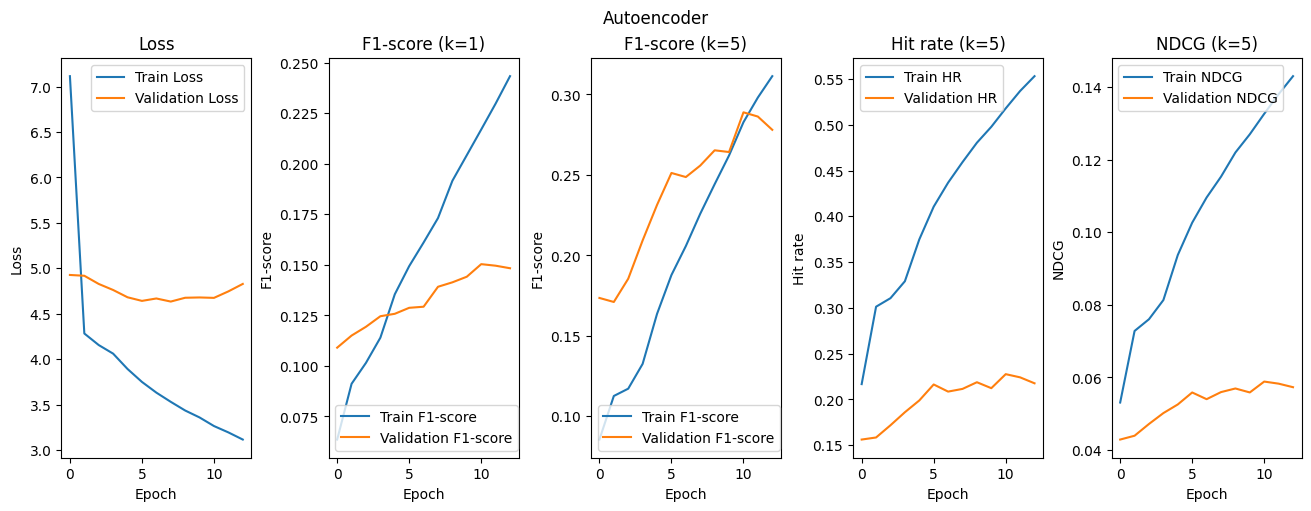

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0762 - f1_score: 0.0900 - f1_score_at_k: 0.1708 - hit_rate_at_k: 0.1295 - loss: 5.1651 - ndcg_at_k: 0.0346       
Test loss: 4.8378
Test accuracy: 0.1231
Test F1@1: 0.1548
Test F1@5: 0.2754
Test HR@5: 0.214
Test NDCG@5: 0.0573


In [47]:
parameters

{'user': 'users-2',
 'user_id': 'A22CW0ZHY3NJH8',
 'number_of_sequences_and_targets_before_removal': 65216,
 'number_of_sequences_and_targets_after_removal': 64030,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 54279,
 'num_unique_product_ids_in_targets': 274,
 'num_unique_product_ids_in_sequences': 24814,
 'number_of_sequences_and_targets_train': 43403,
 'number_of_sequences_and_targets_validation': 5432,
 'number_of_sequences_and_targets_test': 5444,
 'number_of_unique_products_in_targets_train': 268,
 'number_of_unique_products_in_targets_validation': 272,
 'number_of_unique_products_in_targets_test': 274,
 'model_lstm_test_loss': 4.743081092834473,
 'model_lstm_test_accuracy': 0.1286,
 'model_lstm_test_f1_score_k_1': 0.1636,
 'model_lstm_test_f1_score_k_5': 0.3023,
 'model_lstm_test_hr': 0.2341,
 'model_lstm_test_ndcg': 0.0617,
 'model_bi_lstm_test_loss': 4.963522434234619,
 'model_bi_lstm_test_accuracy': 0.1328,
 'model_bi_lstm_test_f1_score_k_1': 0.

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A22CW0ZHY3NJH8', 'sequence': [111124, 139194], 'target': 139291}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 1.0
NDCG@50: 0.014471723698079586
-------------
HT@100: 1.0
NDCG@100: 0.008914243429899216
-------------
HT@200: 1.0
NDCG@200: 0.005360792391002178
-------------
HT@300: 1.0
NDCG@300: 0.003939571790397167
-------------
HT@400: 1.0
NDCG@400: 0.003152271034196019
-------------
HT@500: 1.0
NDCG@500: 0.0026454206090420485
-------------
